In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import xarray as xr
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

from disp_xr.log.logging import setup_logging
from disp_xr import product, quality_metrics, utils, stack as st
from disp_xr.io import write_geotiff, get_geospatial_info

logger = logging.getLogger('disp_xr')
setup_logging(logger_name='disp_xr')

In [3]:
# Get DISP version 0.9 data
disp_df = product.get_disp_info('/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622')

if disp_df.version.unique().size >1:
    raise ValueError('Multiple versions found in DISP data. Please filter to a single version.')

[INFO|product|L23] 2025-02-21T16:51:32-0800: Found OPERA DISP: 687 products
[INFO|product|L42] 2025-02-21T16:51:32-0800:  Starting date: 2016-07-16 22:50:42
[INFO|product|L43] 2025-02-21T16:51:32-0800:  Ending date: 2024-12-13 22:51:21
[INFO|product|L47] 2025-02-21T16:51:32-0800:  Versions: ['v1.0' 'v0.8' 'v1.1']
[INFO|product|L51] 2025-02-21T16:51:32-0800:  filtered with >= v1.1: 239 products
[INFO|product|L54] 2025-02-21T16:51:32-0800:  Number of reference dates: 16
[INFO|product|L91] 2025-02-21T16:51:32-0800:  Skip 0 duplicates


In [1]:
stack

NameError: name 'stack' is not defined

In [4]:
from dask.distributed import Client

client = Client(n_workers=6, threads_per_worker=4)
client.dashboard_link

'http://127.0.0.1:8787/status'

Task exception was never retrieved
future: <Task finished name='Task-1149964' coro=<Client._gather.<locals>.wait() done, defined at /u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1149917' coro=<Client._gather.<locals>.wait() done, defined at /u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <

In [5]:
client.close()

In [5]:
disp_df.groupby(by='date1').apply(lambda x: x).groupby(level=0).size()


/tmp/ipykernel_36462/3821814286.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  disp_df.groupby(by='date1').apply(lambda x: x).groupby(level=0).size()


date1
20160716     1
20160926    28
20171003    15
20180425    15
20181022    15
20190514    15
20191110    15
20200508    15
20201104    15
20210527    15
20211205    15
20220603    15
20221212    15
20230610    15
20231219    15
20240616    15
dtype: int64

In [6]:
stack = st.combine_disp_product(disp_df, start_date='20160926')

[INFO|stack|L25] 2025-02-21T16:51:56-0800: Stacking into common stack
[INFO|stack|L27] 2025-02-21T16:51:56-0800:  Chunk blocks: {'time': -1, 'x': 512, 'y': 512}
[INFO|logging|L75] 2025-02-21T16:52:08-0800: Total elapsed time for disp_xr.stack.combine_disp_product: 0.19 minutes (11.55 seconds)


In [7]:
stack1 = stack.chunk({'time':-1, 'x':512, 'y':512})
stack2 = stack.chunk({'time':15, 'x':512, 'y':512})

In [51]:
# Load temporal coherence stack with chunking strategy that avoid chunking along time dim
#stack = xr.open_mfdataset(disp_df.path.to_list(),
#                          data_vars=["temporal_coherence"],
#                          combine="by_coords", coords='minimal',
#                          compat='override')#, combine_attrs='override') 
#stack = stack.chunk({'time':-1, 'x':512, 'y':512})

In [60]:
client.close()

In [12]:
# Load temporal coherence stack with chunking strategy along time dime (15 images due to ministack strategy)
stack2 = xr.open_mfdataset(
    disp_df.path.to_list(),
    data_vars=["temporal_coherence", "persistent_scatterer_mask", "recommended_mask"],
    #combine="by_coords", coords='minimal', compat='override',
    concat_dim="time", combine="nested", coords='minimal', compat='override',
    parallel=True,
    chunks={'temporal_coherence': {'time': 15, 'x': 512, 'y': 512}},
    #engine='netcdf4'
)

stack2 = stack2.chunk({'time':15, 'x':512, 'y':512})

RuntimeError: NetCDF: Not a valid ID

In [38]:
%%time

substacks, reference_dates = product._get_reference_dates(disp_df)
stacks = []
chunks = {'time':-1, 'x':512, 'y':512} 
kwargs = dict(concat_dim="time", combine="nested",
              coords='minimal', compat='override',)
for ix, date in enumerate(reference_dates):
    stack_files = substacks.loc[date].sort_index().path.to_list()
    stack1 = xr.open_mfdataset(stack_files,
                              data_vars=["temporal_coherence"],
                              **kwargs)
    stack1 =stack1.chunk(chunks)
    stacks.append(stack1)
stack1 = xr.concat(stacks, dim='time')
stack1 = stack1.chunk({'time':-1, 'x':512, 'y':512})
#del stacks

CPU times: user 23.7 s, sys: 5.07 s, total: 28.8 s
Wall time: 28.9 s


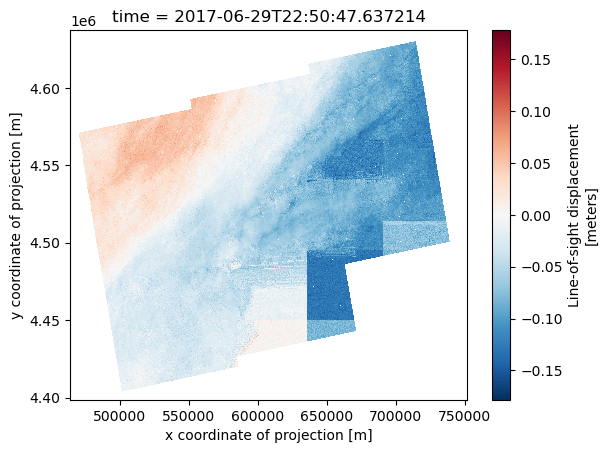

In [57]:
stack1.displacement.isel(time=20).plot.imshow()

In [8]:
# Get chunks locations
chunks_ix = utils.get_chunks_indices(stack)

# Plot one chip for dev
ix = 141
small_stack = stack1.isel(y=chunks_ix[ix][1], x=chunks_ix[ix][2])
small_stack2 = stack2.isel(y=chunks_ix[ix][1], x=chunks_ix[ix][2])

CPU times: user 4.1 s, sys: 1.09 s, total: 5.19 s
Wall time: 5.14 s


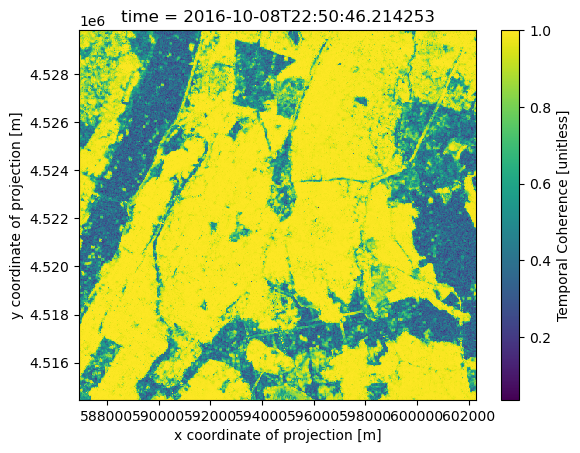

In [11]:
%%time
# Ideally for plotting one epoch, chunking strategy would be time=1
small_stack.temporal_coherence.isel(time=0).plot.imshow()

CPU times: user 252 ms, sys: 32.8 ms, total: 285 ms
Wall time: 279 ms


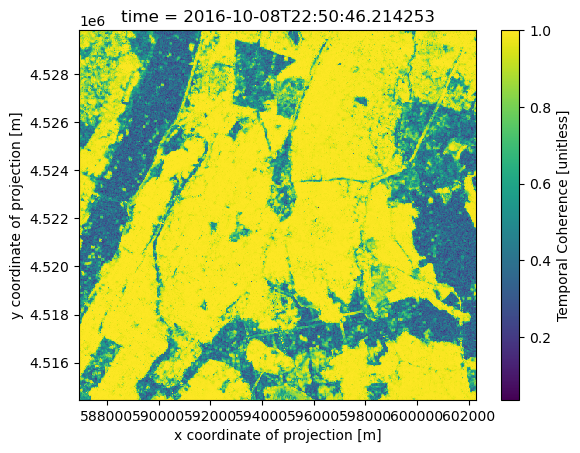

In [12]:
%%time
small_stack2.temporal_coherence.isel(time=0).plot.imshow()

In [28]:
client.close()

In [12]:
%%time
d1 = quality_metrics.get_stack_stat(small_stack.temporal_coherence, mode='median')

CPU times: user 658 ms, sys: 250 ms, total: 908 ms
Wall time: 6.99 s


In [13]:
%%time
d2 = quality_metrics.get_stack_stat(small_stack2.temporal_coherence, mode='median')

CPU times: user 769 ms, sys: 205 ms, total: 974 ms
Wall time: 4.25 s


In [15]:
xr.testing.assert_allclose(d1, d2, rtol=1e-5, atol=1e-5)

In [17]:
%%time 
d11 = quality_metrics.get_stack_stat(stack1.temporal_coherence, mode='median')

/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 54.23 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/_task_spec.py:740: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/_task_spec.py:740: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/_task_spec.py:740: RuntimeWarning: All-NaN slice encountered
  return self.func(*new

CPU times: user 1min 49s, sys: 18.3 s, total: 2min 8s
Wall time: 4min 27s


In [24]:
stack2 = stack.chunk({'time':50, 'x':512, 'y':512})

In [25]:
stack2

<xarray.Dataset> Size: 799GB
Dimensions:                         (time: 238, y: 7959, x: 9587)
Coordinates:
  * y                               (y) float64 64kB 4.637e+06 ... 4.399e+06
  * x                               (x) float64 77kB 4.641e+05 ... 7.516e+05
  * time                            (time) datetime64[ns] 2kB 2016-10-08T22:5...
Data variables: (12/13)
    spatial_ref                     (time) int64 2kB dask.array<chunksize=(50,), meta=np.ndarray>
    reference_time                  (time) datetime64[ns] 2kB dask.array<chunksize=(50,), meta=np.ndarray>
    displacement                    (time, y, x) float32 73GB dask.array<chunksize=(50, 512, 512), meta=np.ndarray>
    short_wavelength_displacement   (time, y, x) float32 73GB dask.array<chunksize=(50, 512, 512), meta=np.ndarray>
    recommended_mask                (time, y, x) float32 73GB dask.array<chunksize=(50, 512, 512), meta=np.ndarray>
    connected_component_labels      (time, y, x) float32 73GB dask.array<chunksize=(50, 512, 512), meta=np.ndarray>
    ...                              ...
    estimated_phase_quality         (time, y, x) float32 73GB dask.array<chunksize=(50, 512, 512), meta=np.ndarray>
    persistent_scatterer_mask       (time, y, x) float32 73GB dask.array<chunksize=(50, 512, 512), meta=np.ndarray>
    shp_counts                      (time, y, x) float32 73GB dask.array<chunksize=(50, 512, 512), meta=np.ndarray>
    water_mask                      (time, y, x) float32 73GB dask.array<chunksize=(50, 512, 512), meta=np.ndarray>
    phase_similarity                (time, y, x) float32 73GB dask.array<chunksize=(50, 512, 512), meta=np.ndarray>
    timeseries_inversion_residuals  (time, y, x) float32 73GB dask.array<chunksize=(50, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.8
    contact:             opera-sds-ops@jpl.nasa.gov
    institution:         NASA JPL
    mission_name:        OPERA
    reference_document:  JPL D-108765
    title:               OPERA_L3_DISP-S1 Product

In [26]:
%%time 
d22 = quality_metrics.get_stack_stat(stack2.temporal_coherence, mode='median')

/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 49.83 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


KeyboardInterrupt: 

In [23]:
xr.testing.assert_allclose(d11, d22, rtol=1e-5, atol=1e-5)

In [55]:
def get_value_percentage(stack_xr:xr.Dataset, value:int, reverse=False):
    template = quality_metrics.get_template(stack_xr)
    data = stack_xr.map_blocks(quality_metrics.get_counts,
                               kwargs={'label':value, 'reverse':reverse},
                               template=template)

    if template.sizes['time'] > 1:
            data = data.sum(dim='time').values
    else:
        data = np.squeeze(data.values)

    pct = data / np.int64(stack_xr.time.size) * 100
    return pct

In [52]:
small_stack

<xarray.Dataset> Size: 3GB
Dimensions:                         (time: 238, y: 512, x: 512)
Coordinates:
  * y                               (y) float64 4kB 4.53e+06 ... 4.514e+06
  * x                               (x) float64 4kB 5.869e+05 ... 6.023e+05
  * time                            (time) datetime64[ns] 2kB 2016-10-08T22:5...
Data variables: (12/13)
    spatial_ref                     (time) int64 2kB dask.array<chunksize=(238,), meta=np.ndarray>
    reference_time                  (time) datetime64[ns] 2kB dask.array<chunksize=(238,), meta=np.ndarray>
    displacement                    (time, y, x) float32 250MB dask.array<chunksize=(238, 512, 512), meta=np.ndarray>
    short_wavelength_displacement   (time, y, x) float32 250MB dask.array<chunksize=(238, 512, 512), meta=np.ndarray>
    recommended_mask                (time, y, x) float32 250MB dask.array<chunksize=(238, 512, 512), meta=np.ndarray>
    connected_component_labels      (time, y, x) float32 250MB dask.array<chunksize=(238, 512, 512), meta=np.ndarray>
    ...                              ...
    estimated_phase_quality         (time, y, x) float32 250MB dask.array<chunksize=(238, 512, 512), meta=np.ndarray>
    persistent_scatterer_mask       (time, y, x) float32 250MB dask.array<chunksize=(238, 512, 512), meta=np.ndarray>
    shp_counts                      (time, y, x) float32 250MB dask.array<chunksize=(238, 512, 512), meta=np.ndarray>
    water_mask                      (time, y, x) float32 250MB dask.array<chunksize=(238, 512, 512), meta=np.ndarray>
    phase_similarity                (time, y, x) float32 250MB dask.array<chunksize=(238, 512, 512), meta=np.ndarray>
    timeseries_inversion_residuals  (time, y, x) float32 250MB dask.array<chunksize=(238, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.8
    contact:             opera-sds-ops@jpl.nasa.gov
    institution:         NASA JPL
    mission_name:        OPERA
    reference_document:  JPL D-108765
    title:               OPERA_L3_DISP-S1 Product

In [60]:
%%time
d11 = get_value_percentage(stack1.persistent_scatterer_mask, value=1)

/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 52.40 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 2min 23s, sys: 20.5 s, total: 2min 44s
Wall time: 4min 34s


In [61]:
%%time
d22 = get_value_percentage(stack2.persistent_scatterer_mask, value=1)

/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 65.66 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 2min 43s, sys: 22.7 s, total: 3min 6s
Wall time: 4min 27s


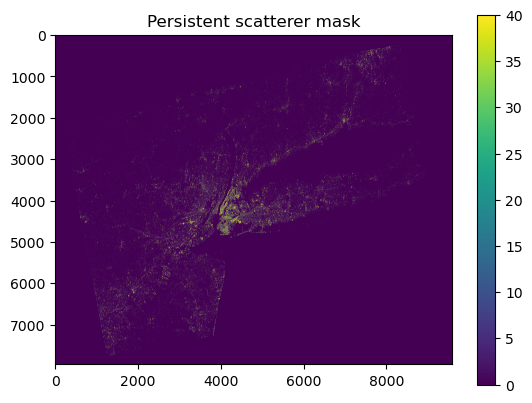

In [67]:
plt.imshow(d22, clim=[0,40], cmap='viridis')
plt.title('Persistent scatterer mask')
plt.colorbar()

In [62]:
np.testing.assert_allclose(d11, d22, rtol=1e-5, atol=1e-5)

# OPTIMIZE STAT CALCULATION WITH MAP_BLOCK
Beware that map_block runs function over a block (chunk) and concat block results at the end, thus chunking strategy can influence the final result. If stat calculation is itendened for stack variables along time dimension, then ideally block should include all epochs in time dimension, e.g. mean(block U all epochs) will differ than mean (block_chunkx1). Downside is that running stats along whole time dim can lead to overhead on reading, whereas reading of indvidual block can speed things up

## MEAN

In [9]:
%%time
# Demonstrate difference in using map_block with different chunking strategy
mean1 = quality_metrics.get_tcoh_stat(small_stack, 'mean')

[INFO|quality_metrics|L139] 2025-02-18T22:35:28-0800: Get mean temporal coherence


CPU times: user 7.63 s, sys: 1.31 s, total: 8.94 s
Wall time: 14.4 s


In [10]:
%%time
mean1_1 = small_stack2.temporal_coherence.mean(dim='time')
mean1_1.compute()

CPU times: user 6.88 s, sys: 1.02 s, total: 7.9 s
Wall time: 10.8 s


<xarray.DataArray 'temporal_coherence' (y: 512, x: 512)> Size: 1MB
array([[0.96863663, 0.68413436, 0.8596802 , ..., 0.97708565, 0.9811837 ,
        0.96153915],
       [0.9349278 , 0.7940238 , 0.86703926, ..., 0.94121444, 0.9649658 ,
        0.9870257 ],
       [0.924142  , 0.8074428 , 0.54773384, ..., 0.9505092 , 0.9431414 ,
        0.9982997 ],
       ...,
       [0.44157192, 0.46588135, 0.4701233 , ..., 0.9882638 , 0.97372   ,
        0.9885254 ],
       [0.44624546, 0.4583544 , 0.5875985 , ..., 0.9879848 , 0.9678868 ,
        0.9904872 ],
       [0.4141715 , 0.50563705, 0.58118546, ..., 0.96286446, 0.97437394,
        0.99686104]], shape=(512, 512), dtype=float32)
Coordinates:
  * y        (y) float64 4kB 4.53e+06 4.53e+06 4.53e+06 ... 4.515e+06 4.514e+06
  * x        (x) float64 4kB 5.869e+05 5.87e+05 5.87e+05 ... 6.022e+05 6.023e+05

In [ ]:
%%time
# Demonstrate difference in using map_block with different chunking strategy
mean2 = quality_metrics.get_tcoh_stat(stack2.isel(y=slice(0,3000),
                                                  x=slice(0,3000)),
                                    'mean')

[INFO|quality_metrics|L139] 2025-02-18T22:42:23-0800: Get mean temporal coherence
/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 85.34 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [12]:
%%time
# Demonstrate difference in using map_block with different chunking strategy
mean2 = quality_metrics.get_tcoh_stat(stack.isel(y=slice(0,2000),
                                                 x=slice(0,2000)),
                                    'mean')

[INFO|quality_metrics|L139] 2025-02-18T22:36:32-0800: Get mean temporal coherence


CPU times: user 30.3 s, sys: 4.43 s, total: 34.7 s
Wall time: 51.5 s


In [18]:
6*304 / 60

30.4

In [13]:
import dask as da

In [13]:
# Map_block results shape
mean1.shape, mean2.shape

((1, 512, 512), (15, 512, 512))

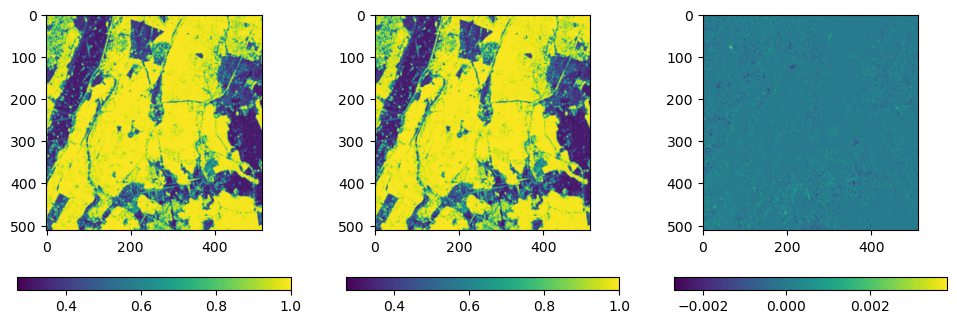

In [14]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
im1 = ax[0].imshow(np.squeeze(mean1))
im2 = ax[1].imshow(np.mean(mean2, axis=0))
im3 = ax[2].imshow(np.squeeze(mean1)-np.mean(mean2, axis=0))
for im, a in zip([im1, im2, im3], ax): fig.colorbar(im, ax=a, location='bottom')

In [30]:
def _get_mblocks_sum(stack_xr: xr.DataArray):
    kwargs = dict(dim='time', skipna=True, keepdims=True)

    # Get template 
    template = quality_metrics.get_template(stack_xr)

    # Get sum
    logger.info('Getting sum along time dim')
    data_sum = stack_xr.map_blocks(lambda x: x.sum(**kwargs),
                                   template=template)
    #data_sum = stack_xr.sum(dim='time', skipna=True, keepdims=True)
    #data_sum = data_sum.compute()
    data_sum = data_sum.values

    if template.sizes['time'] > 1:
        logger.info('Multiple blocks along time dim')
        #data_sum = data_sum.sum(dim='time')
        data_sum = np.sum(data_sum, axis=0)
        return data_sum
    else:
        return np.squeeze(data_sum)
    #return data_sum.squeeze()
    
def _get_mblocks_min(stack_xr: xr.DataArray):
    kwargs = dict(dim='time', skipna=True, keepdims=True)

    # Get template 
    template = quality_metrics.get_template(stack_xr)

    # Get sum
    logger.info('Getting min along time dim')
    data_min = stack_xr.map_blocks(lambda x: x.min(**kwargs),
                                   template=template)

    if template.sizes['time'] > 1:
        logger.info('Multiple blocks along time dim')
        data_min = data_min.min(dim='time')
        return data_min.values
    else:
        data_min = data_min.values
        return np.squeeze(data_min)
    
def _get_mblocks_max(stack_xr: xr.DataArray):
    kwargs = dict(dim='time', skipna=True, keepdims=True)

    # Get template 
    template = quality_metrics.get_template(stack_xr)

    # Get sum
    logger.info('Getting max along time dim')
    data_max = stack_xr.map_blocks(lambda x: x.max(**kwargs),
                                   template=template)
    if template.sizes['time'] > 1:
        logger.info('Multiple blocks along time dim')
        data_max = data_max.max(dim='time')
        return data_max.values
    else:
        data_max = data_max.values
        return np.squeeze(data_max)    

In [16]:
def _get_mblocks_mean(stack_xr: xr.DataArray):
    # Get sum of values along time dim
    data_sum = _get_mblocks_sum(stack_xr)

    return data_sum / len(stack_xr.time)

In [17]:
%%time
mean1_1 = _get_mblocks_mean(small_stack.temporal_coherence)

[INFO|1790876865|L8] 2025-02-18T21:13:57-0800: Getting sum along time dim


CPU times: user 6.69 s, sys: 1.63 s, total: 8.33 s
Wall time: 11 s


In [22]:
%%time
data_sum1 = small_stack.temporal_coherence.mean(dim='time', skipna=True, keepdims=True)
data_sum1 = data_sum1.compute()

CPU times: user 7.42 s, sys: 1.77 s, total: 9.19 s
Wall time: 11.3 s


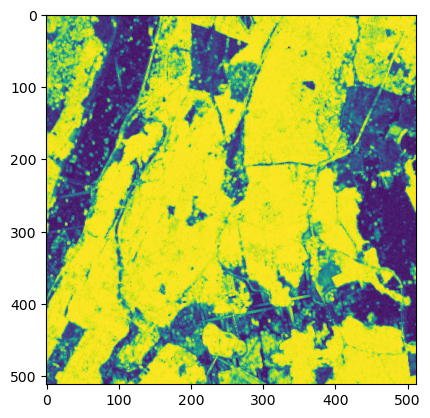

In [24]:
plt.imshow(data_sum1.squeeze())

In [17]:
%%time
d = _get_mblocks_mean(stack2.temporal_coherence)

[INFO|1790876865|L8] 2025-02-18T15:24:05-0800: Getting sum along time dim
/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 338.29 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 12min 51s, sys: 1min 50s, total: 14min 41s
Wall time: 14min 42s


In [35]:
%%time
small_stack2.temporal_coherence.mean(dim='time').compute()

CPU times: user 6.82 s, sys: 1.14 s, total: 7.96 s
Wall time: 8.7 s


<xarray.DataArray 'temporal_coherence' (y: 512, x: 512)> Size: 1MB
array([[0.96863663, 0.68413436, 0.8596802 , ..., 0.97708565, 0.9811837 ,
        0.96153915],
       [0.9349278 , 0.7940238 , 0.86703926, ..., 0.94121444, 0.9649658 ,
        0.9870257 ],
       [0.924142  , 0.8074428 , 0.54773384, ..., 0.9505092 , 0.9431414 ,
        0.9982997 ],
       ...,
       [0.44157192, 0.46588135, 0.4701233 , ..., 0.9882638 , 0.97372   ,
        0.9885254 ],
       [0.44624546, 0.4583544 , 0.5875985 , ..., 0.9879848 , 0.9678868 ,
        0.9904872 ],
       [0.4141715 , 0.50563705, 0.58118546, ..., 0.96286446, 0.97437394,
        0.99686104]], shape=(512, 512), dtype=float32)
Coordinates:
  * y        (y) float64 4kB 4.53e+06 4.53e+06 4.53e+06 ... 4.515e+06 4.514e+06
  * x        (x) float64 4kB 5.869e+05 5.87e+05 5.87e+05 ... 6.022e+05 6.023e+05

In [36]:
%%time
_get_mblocks_mean(small_stack2.temporal_coherence)

[INFO|124422669|L8] 2025-02-18T21:20:31-0800: Getting sum along time dim
[INFO|124422669|L15] 2025-02-18T21:20:31-0800: Multiple blocks along time dim
Exception ignored in: <function CachingFileManager.__del__ at 0x7f5d56294ae0>
Traceback (most recent call last):
  File "/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/xarray/backends/file_manager.py", line 250, in __del__
    self.close(needs_lock=False)
  File "/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/xarray/backends/file_manager.py", line 234, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2669, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2636, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2164, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not a valid ID


CPU times: user 7.31 s, sys: 1.4 s, total: 8.7 s
Wall time: 10 s


array([[0.96863663, 0.68413436, 0.8596802 , ..., 0.97708565, 0.9811837 ,
        0.96153915],
       [0.9349278 , 0.7940238 , 0.86703926, ..., 0.94121444, 0.9649658 ,
        0.9870257 ],
       [0.924142  , 0.8074428 , 0.54773384, ..., 0.9505092 , 0.9431414 ,
        0.9982997 ],
       ...,
       [0.44157192, 0.46588135, 0.4701233 , ..., 0.9882638 , 0.97372   ,
        0.9885254 ],
       [0.44624546, 0.4583544 , 0.5875985 , ..., 0.9879848 , 0.9678868 ,
        0.9904872 ],
       [0.4141715 , 0.50563705, 0.58118546, ..., 0.96286446, 0.97437394,
        0.99686104]], shape=(512, 512), dtype=float32)

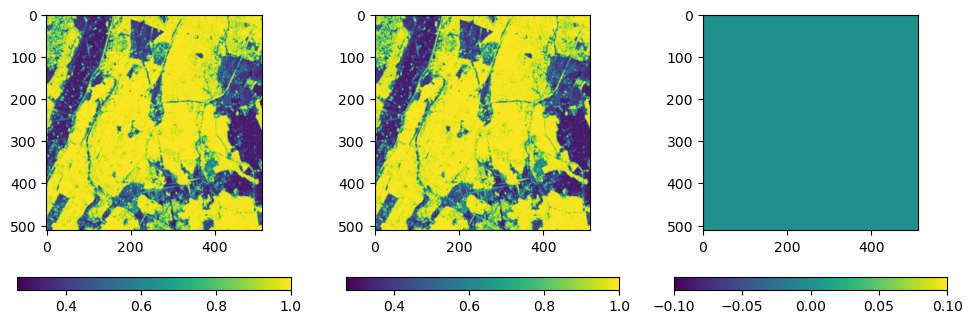

In [37]:
# Getting same result as running mean directly with map_block
fig, ax = plt.subplots(1,3, figsize=(12,4))
im1 = ax[0].imshow(np.squeeze(mean1))
im2 = ax[1].imshow(mean1_1)
im3 = ax[2].imshow(np.squeeze(mean1)-mean1_1)
for im, a in zip([im1, im2, im3], ax): fig.colorbar(im, ax=a, location='bottom')

In [38]:
%%time
mean2_1 = _get_mblocks_mean(small_stack2.temporal_coherence)

[INFO|124422669|L8] 2025-02-18T21:21:25-0800: Getting sum along time dim
[INFO|124422669|L15] 2025-02-18T21:21:25-0800: Multiple blocks along time dim


CPU times: user 7.34 s, sys: 1.35 s, total: 8.69 s
Wall time: 9.98 s


Exception ignored in: <function CachingFileManager.__del__ at 0x7f5d56294ae0>
Traceback (most recent call last):
  File "/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/xarray/backends/file_manager.py", line 250, in __del__
    self.close(needs_lock=False)
  File "/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/xarray/backends/file_manager.py", line 234, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2669, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2636, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2164, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not a valid ID


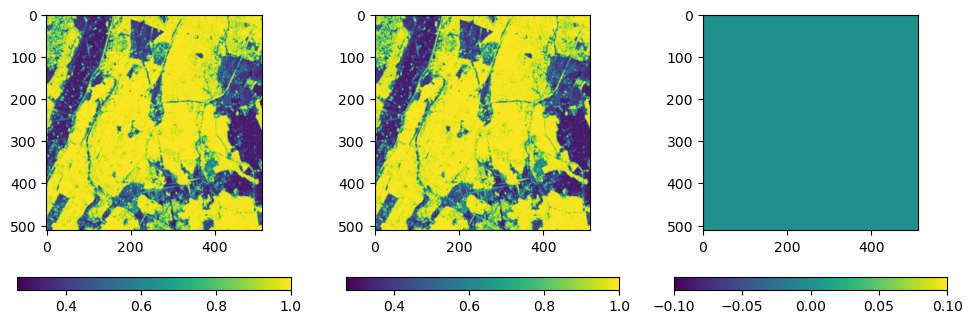

In [49]:
# Getting same mean result from one block and mulitple block along time dim 
fig, ax = plt.subplots(1,3, figsize=(12,4))
im1 = ax[0].imshow(np.squeeze(mean1))
im2 = ax[1].imshow(mean2_1)
im3 = ax[2].imshow(np.squeeze(mean1)-mean2_1)
for im, a in zip([im1, im2, im3], ax): fig.colorbar(im, ax=a, location='bottom')

# STD

In [50]:
%%time
# Demonstrate difference in using map_block with different chunking strategy
std1 = quality_metrics.get_tcoh_stat(small_stack, 'std')

[INFO|quality_metrics|L120] 2025-02-18T10:07:44-0800: Get std temporal coherence


CPU times: user 31.1 s, sys: 3.29 s, total: 34.3 s
Wall time: 33.4 s


In [57]:
%%time
# Demonstrate difference in using map_block with different chunking strategy
std2 = quality_metrics.get_tcoh_stat(small_stack2, 'std')

[INFO|quality_metrics|L120] 2025-02-18T10:12:00-0800: Get std temporal coherence


CPU times: user 31.8 s, sys: 3.15 s, total: 34.9 s
Wall time: 33.2 s


In [52]:
# Map_block results shape
std1.shape, std2.shape

((1, 512, 512), (15, 512, 512))

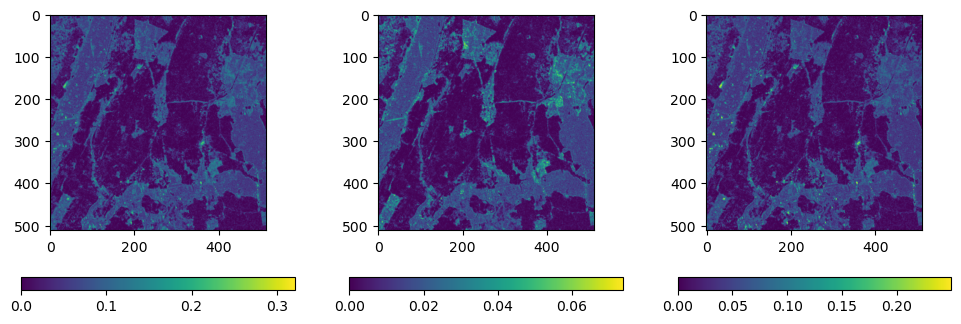

In [54]:
# NOTE: mean of multiple blocks stds could be another interesting way to extract 
# Stats in moving window fashion
fig, ax = plt.subplots(1,3, figsize=(12,4))
im1 = ax[0].imshow(np.squeeze(std1))
im2 = ax[1].imshow(np.mean(std2, axis=0)) # Mean of mulitple blocks std
im3 = ax[2].imshow(np.squeeze(std1)-np.mean(std2, axis=0))
for im, a in zip([im1, im2, im3], ax): fig.colorbar(im, ax=a, location='bottom')

In [ ]:
%%time
#Workaround solution as temporal coherence is the same per ministack
# we choose chunking along time to follow dolphin ministack length
# Get out ministack temporal coherence that is same for all epochs within one ministack 
std2_1 = quality_metrics.get_tcoh_stat(small_stack2, 'median')

[INFO|quality_metrics|L120] 2025-02-18T10:11:21-0800: Get median temporal coherence


CPU times: user 38.5 s, sys: 4.54 s, total: 43 s
Wall time: 38.8 s


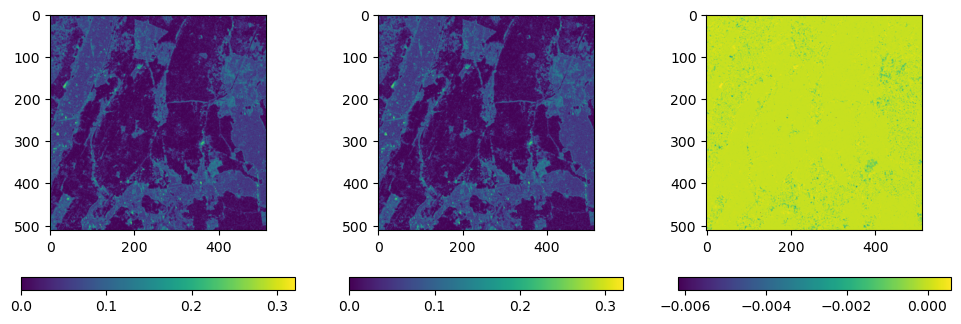

In [58]:
# NOTE: run std over median values from ministacks
# this should be acctually more representative of the 
# temporal coherence std, than option 1
fig, ax = plt.subplots(1,3, figsize=(12,4))
im1 = ax[0].imshow(np.squeeze(std1))
im2 = ax[1].imshow(np.std(std2_1, axis=0)) 
im3 = ax[2].imshow(np.squeeze(std1)-np.std(std2_1, axis=0))
for im, a in zip([im1, im2, im3], ax): fig.colorbar(im, ax=a, location='bottom')

In [60]:
def _get_mblocks_std(stack_xr:xr.DataArray):
    # Get mean
    logger.info('Getting stack mean')
    data_mean = _get_mblocks_mean(stack_xr)

    # Get squared difference between values and mean
    logger.info('Getting squared differences')
    data_squared = (stack_xr - data_mean)**2

    # Get sum
    sum_squared = _get_mblocks_sum(data_squared)
    logger.info('Getting standard dev.')
    data_std = np.sqrt(sum_squared / len(small_stack2.time))
    return data_std

In [61]:
%%time
std1_1 = _get_mblocks_std(small_stack.temporal_coherence)

[INFO|2273690327|L3] 2025-02-18T10:19:35-0800: Getting stack mean
[INFO|3258220249|L8] 2025-02-18T10:19:35-0800: Getting sum along time dim
[INFO|2273690327|L7] 2025-02-18T10:20:09-0800: Getting squared differences
[INFO|3258220249|L8] 2025-02-18T10:20:09-0800: Getting sum along time dim
[INFO|2273690327|L12] 2025-02-18T10:20:43-0800: Getting standard dev.


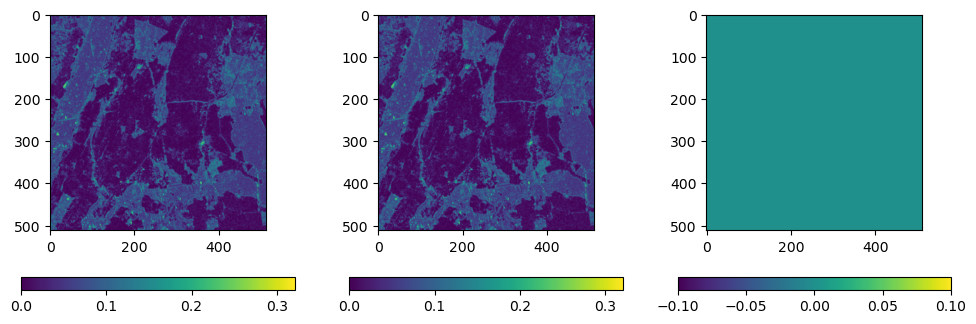

In [62]:
# Getting same result as running std directly with map_block
fig, ax = plt.subplots(1,3, figsize=(12,4))
im1 = ax[0].imshow(np.squeeze(std1))
im2 = ax[1].imshow(std1_1)
im3 = ax[2].imshow(np.squeeze(std1)-std1_1)
for im, a in zip([im1, im2, im3], ax): fig.colorbar(im, ax=a, location='bottom')

In [63]:
%%time
std2_2 = _get_mblocks_std(small_stack2.temporal_coherence)

[INFO|2273690327|L3] 2025-02-18T10:21:09-0800: Getting stack mean
[INFO|3258220249|L8] 2025-02-18T10:21:09-0800: Getting sum along time dim
[INFO|3258220249|L12] 2025-02-18T10:21:09-0800: Multiple blocks along time dim
[INFO|2273690327|L7] 2025-02-18T10:21:42-0800: Getting squared differences
[INFO|3258220249|L8] 2025-02-18T10:21:42-0800: Getting sum along time dim
[INFO|3258220249|L12] 2025-02-18T10:21:42-0800: Multiple blocks along time dim
[INFO|2273690327|L12] 2025-02-18T10:22:15-0800: Getting standard dev.


CPU times: user 1min 3s, sys: 6.53 s, total: 1min 9s
Wall time: 1min 6s


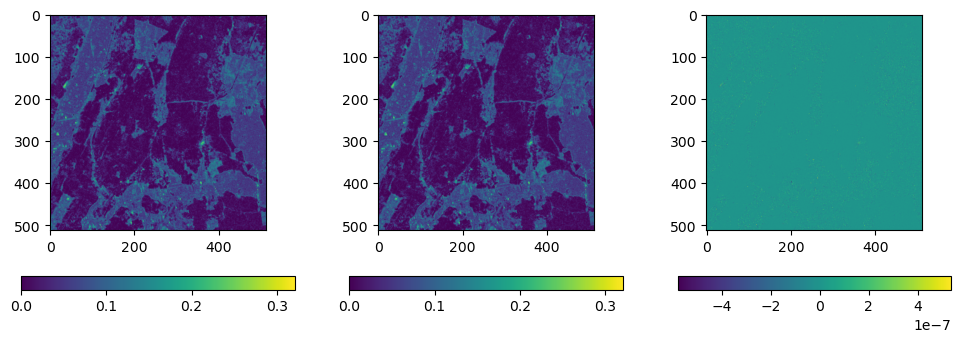

In [64]:
# Close enough result as running std directly with map_block
# Differences due to rounding 
fig, ax = plt.subplots(1,3, figsize=(12,4))
im1 = ax[0].imshow(np.squeeze(std1))
im2 = ax[1].imshow(std2_2)
im3 = ax[2].imshow(np.squeeze(std1)-std2_2)
for im, a in zip([im1, im2, im3], ax): fig.colorbar(im, ax=a, location='bottom')

## MEDIAN

In [74]:
def _get_mblocks_median(stack_xr: xr.DataArray):
    kwargs = dict(dim='time', skipna=True, keepdims=True)

    # Get template 
    template = quality_metrics.get_template(stack_xr)

    # Get sum
    logger.info('Getting sum along time dim')
    data = stack_xr.map_blocks(lambda x: x.median(**kwargs),
                                   template=template)
    if template.sizes['time'] > 1:
        logger.info('Multiple blocks along time dim')
        data = data.median(dim='time')
        return data.values
    else:
        data = data.values
        return np.squeeze(data)
    

In [75]:
%%time
median1 = quality_metrics.get_tcoh_stat(small_stack, 'median')

[INFO|quality_metrics|L120] 2025-02-18T10:35:16-0800: Get median temporal coherence


CPU times: user 35.6 s, sys: 3.83 s, total: 39.5 s
Wall time: 38.6 s


In [76]:
%%time
median1_1 = _get_mblocks_median(small_stack.temporal_coherence)

[INFO|4151039406|L8] 2025-02-18T10:35:55-0800: Getting sum along time dim


CPU times: user 41.1 s, sys: 4.74 s, total: 45.8 s
Wall time: 44.2 s


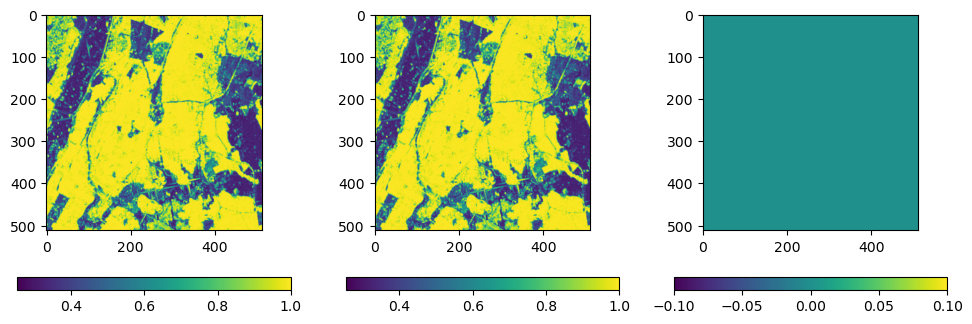

In [77]:
# Getting same result as running std directly with map_block
fig, ax = plt.subplots(1,3, figsize=(12,4))
im1 = ax[0].imshow(np.squeeze(median1))
im2 = ax[1].imshow(median1_1)
im3 = ax[2].imshow(np.squeeze(median1)-median1_1)
for im, a in zip([im1, im2, im3], ax): fig.colorbar(im, ax=a, location='bottom')

In [78]:
%%time
median2_1 = quality_metrics.get_tcoh_stat(small_stack2, 'median')

[INFO|quality_metrics|L120] 2025-02-18T10:41:40-0800: Get median temporal coherence


CPU times: user 34.4 s, sys: 3.96 s, total: 38.3 s
Wall time: 34.3 s


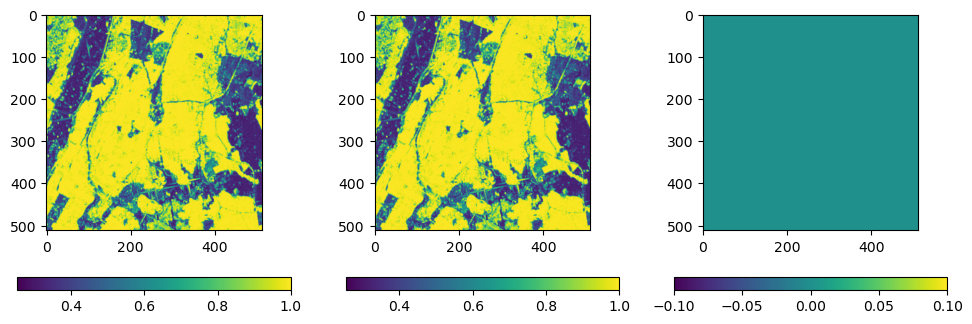

In [ ]:
# Getting same result as running std directly with map_block
# NOTE this is due to chunking strategy if time chunks are different than 15, this would be slightly different
fig, ax = plt.subplots(1,3, figsize=(12,4))
im1 = ax[0].imshow(np.squeeze(median1))
im2 = ax[1].imshow(np.median(median2_1, axis=0))
im3 = ax[2].imshow(np.squeeze(median1)-np.median(median2_1, axis=0))
for im, a in zip([im1, im2, im3], ax): fig.colorbar(im, ax=a, location='bottom')

In [82]:
%%time
median2_2 = _get_mblocks_median(small_stack2.temporal_coherence)

[INFO|4151039406|L8] 2025-02-18T10:44:29-0800: Getting sum along time dim
[INFO|4151039406|L12] 2025-02-18T10:44:29-0800: Multiple blocks along time dim


CPU times: user 35.5 s, sys: 4.96 s, total: 40.5 s
Wall time: 36.3 s


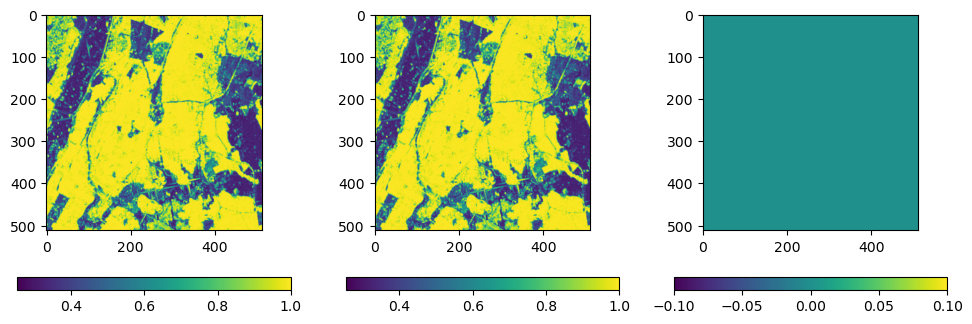

In [83]:
# Getting same result as running std directly with map_block
fig, ax = plt.subplots(1,3, figsize=(12,4))
im1 = ax[0].imshow(np.squeeze(median1))
im2 = ax[1].imshow(median2_2)
im3 = ax[2].imshow(np.squeeze(median1)-median2_2)
for im, a in zip([im1, im2, im3], ax): fig.colorbar(im, ax=a, location='bottom')

## MIN/MAX

In [68]:
%%time
# Demonstrate difference in using map_block with different chunking strategy
min1 = quality_metrics.get_tcoh_stat(small_stack, 'min')

[INFO|quality_metrics|L120] 2025-02-18T10:29:25-0800: Get min temporal coherence


CPU times: user 31 s, sys: 2.63 s, total: 33.6 s
Wall time: 32.7 s


In [69]:
%%time
# Demonstrate difference in using map_block with different chunking strategy
min1_1 = _get_mblocks_min(small_stack.temporal_coherence)

[INFO|3222765495|L26] 2025-02-18T10:30:23-0800: Getting min along time dim


CPU times: user 31.2 s, sys: 2.87 s, total: 34.1 s
Wall time: 33.1 s


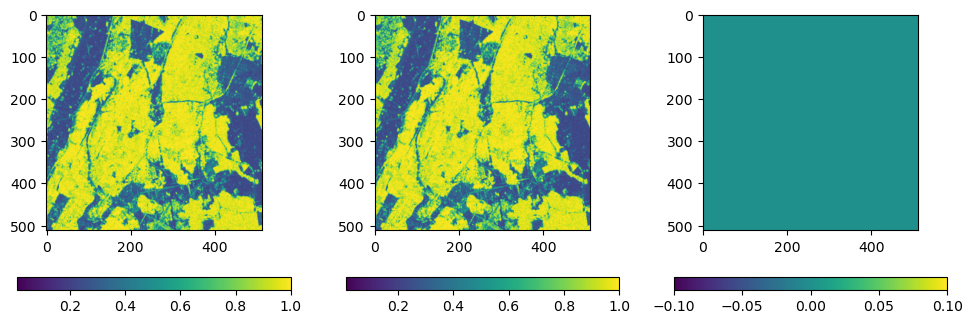

In [ ]:
# Getting same results with different functions
fig, ax = plt.subplots(1,3, figsize=(12,4))
im1 = ax[0].imshow(np.squeeze(min1))
im2 = ax[1].imshow(min1_1)
im3 = ax[2].imshow(np.squeeze(min1)-min1_1)
for im, a in zip([im1, im2, im3], ax): fig.colorbar(im, ax=a, location='bottom')

In [72]:
%%time
# Demonstrate difference in using map_block with different chunking strategy
min2 = _get_mblocks_min(small_stack2.temporal_coherence)

[INFO|3222765495|L26] 2025-02-18T10:31:56-0800: Getting min along time dim
[INFO|3222765495|L30] 2025-02-18T10:31:56-0800: Multiple blocks along time dim


CPU times: user 31.3 s, sys: 2.79 s, total: 34.1 s
Wall time: 33 s


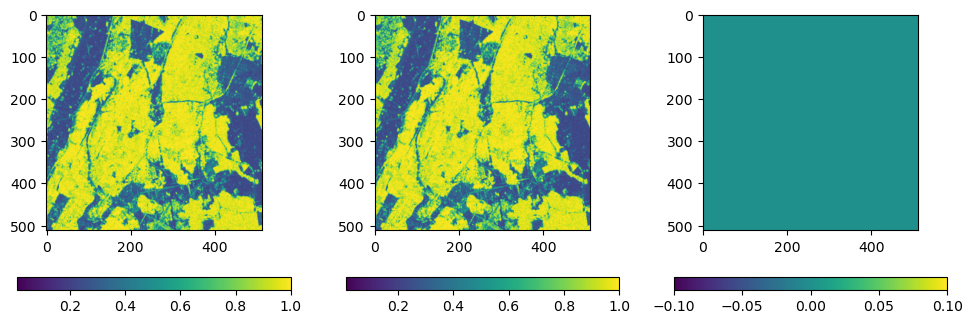

In [73]:
# Getting same results with different functions
fig, ax = plt.subplots(1,3, figsize=(12,4))
im1 = ax[0].imshow(np.squeeze(min1))
im2 = ax[1].imshow(min2)
im3 = ax[2].imshow(np.squeeze(min1)-min2)
for im, a in zip([im1, im2, im3], ax): fig.colorbar(im, ax=a, location='bottom')

## PCT

In [87]:
small_stack

<xarray.Dataset> Size: 244MB
Dimensions:                        (time: 224, y: 512, x: 512)
Coordinates:
  * y                              (y) float64 4kB 4.53e+06 ... 4.514e+06
  * x                              (x) float64 4kB 5.869e+05 ... 6.023e+05
  * time                           (time) datetime64[ns] 2kB 2016-09-26T22:50...
Data variables:
    spatial_ref                    int64 8B ...
    reference_time                 (time) datetime64[ns] 2kB dask.array<chunksize=(224,), meta=np.ndarray>
    displacement                   (y, x) float32 1MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    short_wavelength_displacement  (y, x) float32 1MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    recommended_mask               (y, x) float32 1MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    connected_component_labels     (y, x) float32 1MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    temporal_coherence             (time, y, x) float32 235MB dask.array<chunksize=(224, 512, 512), meta=np.ndarray>
    estimated_phase_quality        (y, x) float32 1MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    persistent_scatterer_mask      (y, x) float32 1MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    shp_counts                     (y, x) float32 1MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    water_mask                     (y, x) float32 1MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    phase_similarity               (y, x) float32 1MB dask.array<chunksize=(512, 512), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.8
    contact:             opera-sds-ops@jpl.nasa.gov
    institution:         NASA JPL
    mission_name:        OPERA
    reference_document:  JPL D–108765
    title:               OPERA_L3_DISP-S1 Product

In [105]:
%%time
# Demonstrate difference in using map_block with different chunking strategy
ps1 = quality_metrics.get_ps_percentage(small_stack)

[INFO|quality_metrics|L63] 2025-02-18T11:30:48-0800: Get percentage of PS


<xarray.DataArray (time: 1, y: 512, x: 512)> Size: 1MB
dask.array<<this-array>-get_counts, shape=(1, 512, 512), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 4kB 4.53e+06 4.53e+06 4.53e+06 ... 4.515e+06 4.514e+06
  * x        (x) float64 4kB 5.869e+05 5.87e+05 5.87e+05 ... 6.022e+05 6.023e+05
Dimensions without coordinates: time
CPU times: user 36 s, sys: 4.5 s, total: 40.5 s
Wall time: 54.9 s


In [106]:
%%time
# Demonstrate difference in using map_block with different chunking strategy
ps2 = quality_metrics.get_ps_percentage(small_stack2)

[INFO|quality_metrics|L63] 2025-02-18T11:31:44-0800: Get percentage of PS


CPU times: user 30.2 s, sys: 3.2 s, total: 33.4 s
Wall time: 55.1 s


In [107]:
ps1.shape, ps2.shape

((512, 512), (512, 512))

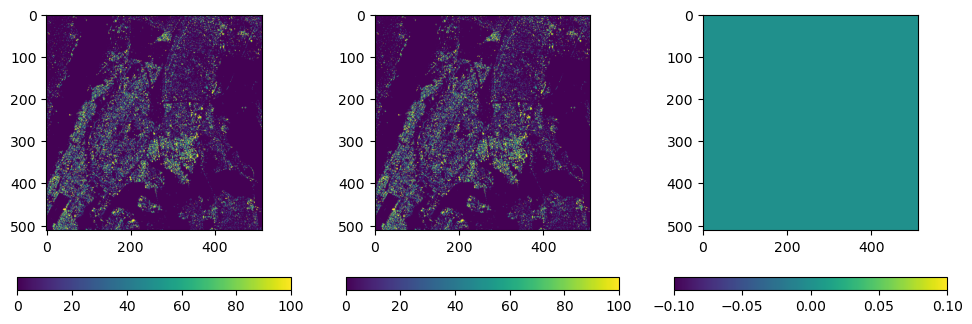

In [108]:
# Getting same results with different functions with adjusted function to account for multiple blocks
fig, ax = plt.subplots(1,3, figsize=(12,4))
im1 = ax[0].imshow(ps1)
im2 = ax[1].imshow(ps2)
im3 = ax[2].imshow(ps1-ps2)
for im, a in zip([im1, im2, im3], ax): fig.colorbar(im, ax=a, location='bottom')

# FULL FRAME TEST

In [9]:
from dask.distributed import Client

client = Client(n_workers=10, threads_per_worker=4)
client.dashboard_link

'http://127.0.0.1:8787/status'

Task exception was never retrieved
future: <Task finished name='Task-31515' coro=<Client._gather.<locals>.wait() done, defined at /home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-31720' coro=<Client._gather.<locals>.wait() done, defined at /home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-31548' coro=<Client._gather.<locals

In [5]:
# Load temporal coherence stack with chunking strategy along time dime (15 images due to ministack strategy)
stack3 = xr.open_mfdataset(disp_df.path.to_list(),
                          data_vars=["temporal_coherence",
                                     "persistent_scatterer_mask"],
                          combine="by_coords", coords='minimal',
                          compat='override')#, combine_attrs='override') 
stack3 = stack.chunk({'time':10, 'x':512, 'y':512})

KeyboardInterrupt: 

Do not understand why do not see speed up, which I saw first time

In [ ]:
%%time
# Graph is size of 690 MB, loading it takes 10 min!!
frame_mean1 = quality_metrics.get_tcoh_stat(stack, 'mean')

[INFO|quality_metrics|L139] 2025-02-18T14:21:01-0800: Get mean temporal coherence


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f6e33534d70>>
Traceback (most recent call last):
  File "/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 687.37 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [ ]:
%%time
# Graph is size of 650 MB, loading it takes 10 min!!
frame_mean2 = _get_mblocks_mean(stack2.temporal_coherence)

In [ ]:
%%time
frame_mean3 = _get_mblocks_mean(stack3.temporal_coherence)

In [ ]:
client.close()